In [1]:
from dataset.dataset import test_train_split, get_meta_gloss_dataloader, SignGlossDataset
import random
import numpy as np
import os
import torch

from model.gaussian_noise import GaussianNoise
from torchvision import transforms


seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
generator = torch.Generator()
generator.manual_seed(seed)

transform = transforms.Compose([GaussianNoise(0, 0.001)])
interp_transform = transforms.Compose([GaussianNoise(0, 0.005)])
dataset = SignGlossDataset(transform=transform, max_pad_len=300)

Loading dataset: 100%|██████████| 21080/21080 [00:03<00:00, 5608.95it/s]

Number of classes: 2000
Total dataset length: 21080
Longest sample: 247 frames long, shortest sample: 9 frames long


In [2]:
train_dataset, test_dataset = test_train_split(dataset)

In [3]:
train_dataloader = get_meta_gloss_dataloader(train_dataset, interpolation_transform=interp_transform)
test_dataloader = get_meta_gloss_dataloader(test_dataset, interpolation_transform=interp_transform)

In [4]:
l_support, r_support, b_support, support_labels, l_query, r_query, b_query, query_labels = next(iter(train_dataloader))

In [5]:
print(l_support.shape, r_support.shape, b_support.shape, support_labels.shape, l_query.shape, r_query.shape, b_query.shape)

torch.Size([30, 300, 21, 3]) torch.Size([30, 300, 21, 3]) torch.Size([30, 300, 7, 3]) torch.Size([30]) torch.Size([40, 300, 21, 3]) torch.Size([40, 300, 21, 3]) torch.Size([40, 300, 7, 3])


In [6]:
print(query_labels)

tensor([[9, 4, 6],
        [4, 6, 8],
        [4, 6, 8],
        [6, 8, 6],
        [8, 6, 0],
        [8, 6, 0],
        [6, 0, 7],
        [6, 0, 7],
        [0, 7, 6],
        [7, 6, 5],
        [6, 5, 1],
        [6, 5, 1],
        [6, 5, 1],
        [5, 1, 9],
        [1, 9, 3],
        [1, 9, 3],
        [9, 3, 3],
        [9, 3, 3],
        [3, 3, 0],
        [3, 0, 9],
        [3, 0, 9],
        [0, 9, 1],
        [9, 1, 5],
        [9, 1, 5],
        [1, 5, 4],
        [5, 4, 7],
        [4, 7, 8],
        [7, 8, 3],
        [8, 3, 0],
        [8, 3, 0],
        [3, 0, 1],
        [3, 0, 1],
        [0, 1, 7],
        [1, 7, 2],
        [1, 7, 2],
        [7, 2, 5],
        [2, 5, 2],
        [2, 5, 2],
        [5, 2, 4],
        [5, 2, 4]])


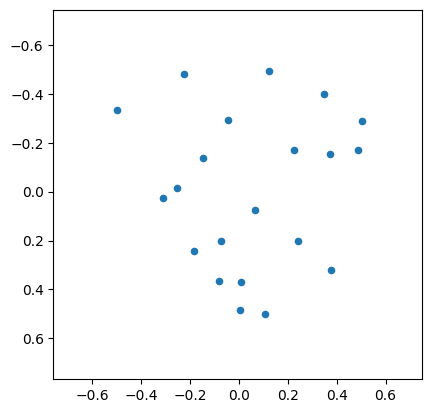

In [7]:
from preprocess.visualize import render
from IPython.display import HTML

anim = render(l_query[0])
HTML(anim.to_jshtml())


In [8]:
l_support, r_support, b_support, support_labels, l_query, r_query, b_query, query_labels = [d.to('cuda') for d in next(iter(test_dataloader))]

In [11]:
from model.model import SiFormerMeta
import torch.nn as nn
import torch.nn.functional as F

def pairwise_distances(x, y):
    # x: (N, D), y: (M, D)
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.norm(x - y, dim=2)

class MetaLearning(nn.Module):
    """
    Custom meta-learning framework in sign language recognition.
    """

    def __init__(self, backbone, n_support = 3, n_query = 3, n_way = 10, max_word = 3):
        super(MetaLearning, self).__init__()
        self.backbone = backbone
        self.n_support = n_support
        self.n_query = n_query
        self.n_way = n_way
        self.max_word = max_word
        self.dist_threshold = nn.Parameter(torch.tensor([5.0]))
    

    def forward(self, l_support, r_support, b_support, l_query, r_query, b_query):

        support_embeddings = self.backbone(l_support, r_support, b_support)
        support_embeddings = support_embeddings[:, 0, :]

        prototypes = torch.mean(support_embeddings.view(self.n_way, self.n_support, -1), dim=1)

        query_embeddings = self.backbone(l_query, r_query, b_query) # (K, words, emb_dim)

        K, *_ = query_embeddings.shape
        dists = pairwise_distances(query_embeddings.view(K*self.max_word, -1), prototypes)

        thresholds = self.dist_threshold.expand(K, self.max_word, 1)

        dists_with_threshold = torch.cat([dists.view(K, self.max_word, -1), thresholds], dim=2) #(K, words, num_classes + 1)

        logits = -dists_with_threshold.view(K*self.max_word, self.n_way + 1)


        return logits



backbone = SiFormerMeta(emb_dim=128, seq_len=300, max_class_per_input=3)
device = 'cuda'
model = MetaLearning(backbone=backbone).to(device)

print(1, torch.cuda.memory_allocated()/1e6)

for _ in range(3):
    print(2, torch.cuda.memory_allocated()/1e6)

    logits = model(l_support, r_support, b_support, l_query, r_query, b_query)

    loss = F.cross_entropy(logits, query_labels.view(-1))
    print(12, torch.cuda.memory_allocated()/1e6)


    correct, total = 0, 0
    with torch.no_grad():
        preds = torch.argmax(logits, dim=1)
        correct += (preds == query_labels.view(-1)).sum().item()
        total += query_labels.size(0)
    print(13, torch.cuda.memory_allocated()/1e6)

    loss.backward()
    torch.cuda.empty_cache()
    print(14, torch.cuda.memory_allocated()/1e6)






Feature isolated transformer
self.selected_attn prob
Encoder with input adaptive
self.selected_attn prob
Encoder with input adaptive
self.selected_attn prob
Encoder with input adaptive
Using custom DecoderLayer
Normal decoder
num_enc_layers 3, num_dec_layers 2, patient 1
1 4770.77248
2 4770.77248
12 9406.991872
13 9406.991872
14 5185.556992
2 5185.556992
12 9426.336256
13 9426.336256
14 5185.556992
2 5185.556992
12 9430.743552
13 9430.743552
14 5185.556992
